### 概览
任务：
利用训练的服饰图像描述模型和多模态大语言模型，为真实背景的服饰图像数据集增加服饰描述和背景描述，构建全新的服饰图像描述数据集。

任务梳理：
+ 利用已经训练的服饰图像描述模型
+ 利用大语言模型
+ 为真实背景的服饰图像数据集增加服饰描述和背景描述
+ 构建全新的服饰图像数据集

输入：
+ dataset/fashion-new/images-raw

输出：
+ dataset/fashion-new/test_captions.json
+ dataset/fashion-new/train_captions.json

重新整理一份数据集，

注意：**需要首先把`images-extra-3.tar.gz`解压到`dataset/fashion-new/images-raw`里面**

需要注意的是，第一次做这一步比较费时间。可能过程会在10分钟左右。

In [1]:
import os
from PIL import Image
import time

def clean_dataset(raw_image_path='../dataset/fashion-new/images-raw'):
    global_idx = 0
    time_start = time.monotonic()
    clean_image_path = '../dataset/fashion-new/images-clean'
    if not os.path.exists(clean_image_path):
        os.mkdir(clean_image_path)
        
    if len(os.listdir(clean_image_path)) > 10:
        print('The clean dataset has already existed.')
        return clean_image_path
    

    image_names = [img_name for img_name in os.listdir(raw_image_path)]
    image_paths = [os.path.join(raw_image_path, img_name) for img_name in image_names]

    # we need to change the name of each image, and store the new image in a new folder
    # we cut the name by `_`

    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')
        img_name = img_path.split('/')[-1]
        img_name = img_name.split('.')[0]
        img_name = img_name.split('_')[-1]
        
        # image number: 0-9999, if the number is less than 4 digits, we add 0 in the front
        img_name = str(global_idx).zfill(4)
        
        new_path = os.path.join(clean_image_path, 'MEN_' + img_name +'.jpg')
        img.save(new_path)
        global_idx += 1

    print(f"Convert finished, time cost: {time.monotonic() - time_start} s")
    return clean_image_path

fashion_new_dataset_path = clean_dataset()

The clean dataset has already existed.


首先我们预先准备我们的模型架构

In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np

from typing import List, Dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super(SelfAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=heads)
        
    def forward(self, feature_maps):
        """
        :param 
            feature_maps: torch.Tensor, shape (batch_size, channels, height, width)
            
        :return: torch.Tensor, shape (batch_size, channels, height, width)
        """
        
        # Reshape feature_maps to (batch_size, width*height, channels) for multihead attention
        batch_size, channels, height, width = feature_maps.size()
        feature_maps = feature_maps.permute(0, 2, 3, 1).reshape(batch_size, height * width, channels)
        # Calculate self-attention (it returns attn_output and attn_output_weights, but we need only the output)
        attn_output, _ = self.multihead_attn(feature_maps, feature_maps, feature_maps)
        # Reshape back to (batch_size, channels, height, width)
        attn_output = attn_output.reshape(batch_size, height, width, channels).permute(0, 3, 1, 2)
        return attn_output
    
# encoder for image, add attention layer
import torchvision.models as models
class ImageEncoder(nn.Module):
    def __init__(self, finetuned=True, heads=8, attn_embed_dim=2048):
        super(ImageEncoder, self).__init__()
        self.model = torchvision.models.resnet101(pretrained=True)  # we use pretrained ImageNet ResNet-101        
        self.grid_rep_extractor = nn.Sequential(*(list(self.model.children())[:-2]))    # ResNet Conv as grid extractor

        self.self_attention = SelfAttention(embed_dim=attn_embed_dim, heads=heads)
        
        for param in self.grid_rep_extractor.parameters():
            param.requires_grad = finetuned
            
    def forward(self, images):
        feature_maps = self.grid_rep_extractor(images)  # (batch_size, 2048, H, W)
        #feature_maps = self.additional_conv(feature_maps)  # (batch_size, attn_embed_dim, H, W)
        out = self.self_attention(feature_maps)
        return out
    
class AdditiveAttention(nn.Module):
    def  __init__(self, query_dim, key_dim, attn_dim):
        super(AdditiveAttention, self).__init__()
        self.attn_w_1_q = nn.Linear(query_dim, attn_dim)
        self.attn_w_1_k = nn.Linear(key_dim, attn_dim)
        self.attn_w_2 = nn.Linear(attn_dim, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, query, key_value):
        """
        shape: 
            query: (batch_size, q_dim)  ===================> Q
            key_value: (batch_size, n_kv, kv_dim) =======> K, V
        """
        
        queries = self.attn_w_1_q(query).unsqueeze(1)               # -> (batch_size, 1, attn_dim)
        keys = self.attn_w_1_k(key_value)                           # -> (batch_size, n_kv, attn_dim)
        attn = self.attn_w_2(self.tanh(queries+keys)).squeeze(2)    # -> (batch_size, n_kv)
        # normalize weights
        attn = self.softmax(attn)                                   # -> (batch_size, n_kv)
        # get the attn output
        
        output = torch.bmm(attn.unsqueeze(1), key_value).squeeze(1) # -> (batch_size, 1, kv_dim)
        return output, attn
    
    
class AttentionDecoder(nn.Module):
    def __init__(self, feature_dim, vocab_size, word_dim, attention_dim, hidden_size, num_layers, dropout=0.5):
        super(AttentionDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, word_dim)
        self.attention = AdditiveAttention(hidden_size, feature_dim, attention_dim)
        self.init_state = nn.Linear(feature_dim, num_layers*hidden_size)
        self.rnn = nn.GRU(word_dim + feature_dim, hidden_size, num_layers)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, image_feature, captions, cap_lens):
        """
            image_feature: the image feature extracted by CNN, 
                            shape (batch_size, feature_dim, grid_height, grid_width)

        """
        # convert image_feature to (batch_size, feature_dim, grid_height*grid_width)
        batch_size, feature_dim = image_feature.size(0), image_feature.size(1)
        # switch the order of grid_height and grid_width
        image_feature = image_feature.permute(0, 2, 3, 1)
        # flatten the feature maps
        image_feature = image_feature.view(batch_size, -1, feature_dim)
        # sort the captions by their lengths
        sorted_cap_lens, sorted_cap_indices = torch.sort(cap_lens, 0, True)
        captions = captions[sorted_cap_indices]
        image_feature = image_feature[sorted_cap_indices]
        
        # get the initial hidden state
        hidden_state = self.init_state(image_feature.mean(axis=1))
        hidden_state = hidden_state.view(
                            batch_size,
                            self.rnn.num_layers,
                            self.rnn.hidden_size).permute(1, 0, 2)
        return image_feature, captions, sorted_cap_lens, sorted_cap_indices, hidden_state

    def forward_step(self, image_feature, curr_cap_embed, hidden_state):
        context, alpha = self.attention(hidden_state[-1], image_feature)
        # (1, real_batch_size, hidden_size+word_dim)
        x = torch.cat((context, curr_cap_embed), dim=-1).unsqueeze(0)
        # x: (1, real_batch_size, hidden_size+word_dim)
        # out: (1, real_batch_size, hidden_size)
        out, hidden_state = self.rnn(x, hidden_state)
        preds = self.fc(self.dropout(out.squeeze(0)))
        return preds, alpha, hidden_state

    def forward(self, image_feature, captions, cap_lens):
        """
            hidden_state: (num_layers, batch_size, hidden_size)
            image_feature:  (batch_size, feature_channel, feature_size)
            captions: (batch_size, )
        """
        image_feature, captions, sorted_cap_lens, sorted_cap_indices, hidden_state \
            = self.init_hidden_state(image_feature, captions, cap_lens)
        batch_size = image_feature.size(0)
        
        # notice: the input length -1, because we don't need to predict the last word
        lengths = sorted_cap_lens.cpu().numpy() - 1

        predictions = torch.zeros(batch_size, lengths[0], self.fc.out_features).to(captions.device)
        alphas = torch.zeros(batch_size, lengths[0], image_feature.shape[1]).to(captions.device)
        # cap_embeds: (batch_size, num_steps, word_dim)
        cap_embeds = self.embed(captions)
        
        # allocate for each image, the step stands for the time step
        for step in range(lengths[0]):
            real_batch_size = np.where(lengths>step)[0].shape[0]
            preds, alpha, hidden_state = self.forward_step(
                            image_feature[:real_batch_size],
                            cap_embeds[:real_batch_size, step, :],
                            hidden_state[:, :real_batch_size, :].contiguous())

            predictions[:real_batch_size, step, :] = preds
            alphas[:real_batch_size, step, :] = alpha
            
        """ARCTIC
            return:
                predictions: (batch_size, max_len, vocab_size)  [16, 74, 109]
                    16 是批次大小
                    74 对每个时间步长的输出
                    109 是词汇表的大小，即模型输出的每个时间步可能的单词数
                alphas: (batch_size, max_len, feature_size)     [16, 74, 49]
                    这可能是与注意力机制相关的输出。
                    16 是批次大小，
                    74 是序列长度，
                    49 可能代表每个时间步中注意力权重的数量或某种内部特征的维度。
                captions: (batch_size, max_len)                 [16, 82]
                lengths: (batch_size, )                         (16,)
                sorted_cap_indices: (batch_size, )              [16]
                    用于跟踪经过排序或处理的标注在原始数据集中的索引。
        """
        return predictions, alphas, captions, lengths, sorted_cap_indices

class ARCTIC(nn.Module):
    def __init__(self, image_code_dim, vocab, word_dim, attention_dim, hidden_size, num_layers):
        super(ARCTIC, self).__init__()
        self.vocab = vocab
        self.vocab_reverse = {idx:word for word,idx in self.vocab.items()}
        self.filtered_token = set({vocab['<pad>'], vocab['<start>'], vocab['<end>']})
        
        # net
        self.encoder = ImageEncoder()
        self.decoder = AttentionDecoder(image_code_dim, len(vocab), word_dim, attention_dim, hidden_size, num_layers)

    def forward(self, images, captions, cap_lens):
        image_code = self.encoder(images)
        return self.decoder(image_code, captions, cap_lens)

    def generate(self, images, beam_k, max_len):
        
        vocab_size = len(self.vocab)
        image_codes = self.encoder(images)
        texts = []
        
        # beamsearch for each image
        for image_code in image_codes:
            gen_sent = self._beam_search(image_code, beam_k, max_len, vocab_size)   
            texts.append(gen_sent)
        return texts
    
    
    def _beam_search(self, image_code, beam_k, max_len, vocab_size):
        """ _beam_search: get a sentence_ids
        this function generate a sentence_ids for a image_feature
        
        """
        # make `k` copies for a image
        image_code: torch.Tensor = image_code.unsqueeze(0).repeat(beam_k, 1, 1, 1)       #  (5，2048)
        # generate k sentences
        cur_sents: torch.Tensor = torch.full((beam_k, 1), self.vocab['<start>'], dtype=torch.long).to(device) # [k, 1] -> k sentence slots
        cur_sent_embed: torch.Tensor = self.decoder.embed(cur_sents)[:, 0, :]
        sent_lens: torch.Tensor = torch.LongTensor([1]*beam_k).to(device)

        image_code, cur_sent_embed, _, _, hidden_state = \
            self.decoder.init_hidden_state(image_code, cur_sent_embed, sent_lens)

        # store generated sentences
        end_sentences = []
        end_probs = []
        probs: torch.Tensor = torch.zeros(beam_k, 1).to(device)       # k slots, each slot has a prob
        k = beam_k
        while True:
            preds, _, hidden_state = self.decoder.forward_step(image_code[:k], cur_sent_embed, hidden_state.contiguous())
            preds: torch.Tensor = nn.functional.log_softmax(preds, dim=1) # get the log probability

            probs = probs.repeat(1, preds.size(1)) + preds
            if cur_sents.size(1) == 1:
                values, indices = probs[0].topk(k, 0, True, True)
            else:
                # convert to 1D
                values, indices = probs.view(-1).topk(k, 0, True, True)

            # now we have the top k candidates, with their probs value and indices
            sent_indices = torch.div(indices, vocab_size, rounding_mode='trunc')
            word_indices = indices % vocab_size

            cur_sents = torch.cat([cur_sents[sent_indices], word_indices.unsqueeze(1)], dim=1)

            end_indices = [idx for idx, word in enumerate(word_indices) if word == self.vocab['<end>']]
            if len(end_indices) > 0:
                end_probs.extend(values[end_indices])
                end_sentences.extend(cur_sents[end_indices].tolist())

                k -= len(end_indices)
                if k == 0:
                    break

            cur_indices = [idx for idx, word in enumerate(word_indices) if word != self.vocab['<end>']]
            
            # update the variables
            if len(cur_indices) > 0:
                cur_sent_indices = sent_indices[cur_indices]
                cur_word_indices = word_indices[cur_indices]

                cur_sents = cur_sents[cur_indices]
                
                probs = values[cur_indices].view(-1,1)
                hidden_state = hidden_state[:,cur_sent_indices,:]
                cur_sent_embed = self.decoder.embed(cur_word_indices.view(-1,1))[:,0,:]

            if cur_sents.size(1) >= max_len:
                break
            
            # loop end
        
        # get the generated sentence with the highest probability
        if len(end_sentences) == 0:
            generate_sentence = cur_sents[0].tolist()
        else:
            generate_sentence = end_sentences[end_probs.index(max(end_probs))]
            
        # tensor garbage collection
        del cur_sents, cur_sent_embed, sent_lens, hidden_state, probs, preds
        
        return generate_sentence
    
    def decode(self, 
               token_ids: List[str] # like: ['I', 'am', 'a', 'student'],
               ) -> List[str]:
        return [self.vocab_reverse[token_id] for token_id in token_ids if token_id not in self.filtered_token]

接下来，我们尝试使用初步的模型推理。



/home/airaiot/miniconda3/envs/adapter/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/airaiot/miniconda3/envs/adapter/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


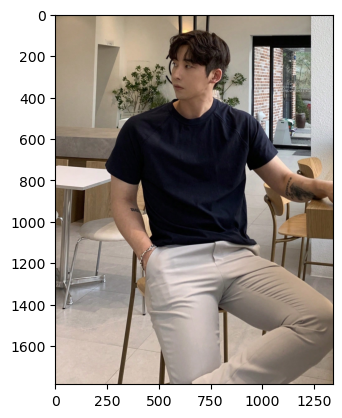

In [3]:
from argparse import Namespace
import os
import json
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

config = Namespace(
    max_len = 80,
    captions_per_image = 1,
    batch_size = 16,
    image_code_dim = 2048,
    word_dim = 512,
    hidden_size = 512,
    attention_dim = 512,
    num_layers = 1,
    encoder_learning_rate = 0.0001,
    decoder_learning_rate = 0.0005,
    num_epochs = 3,
    grad_clip = 5.0,
    alpha_weight = 1.0,
    evaluate_step = 300, 
    checkpoint = None, 
    beam_k = 5,
    scale_factor = 0.2  # 你可以调整这个值，这是RL的缩放因子
)
output_folder = '../output'
ckpt_path = '../output/model_ckpt/attn_rl'

# read vocab and datas
with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

model_arctic = ARCTIC(config.image_code_dim, vocab, config.word_dim, config.attention_dim, config.hidden_size, config.num_layers)

sf_str = str(config.scale_factor).replace('.', '')
model_arctic.load_state_dict(torch.load(os.path.join(ckpt_path, f"best_ARCTIC.pth")))
model_arctic.to(device)

# ================= NOTICE: LOCK =================
model_arctic.eval()    
# ================================================

test_img = Image.open('../dataset/fashion-new/images-raw/test_img.jpg').convert('RGB')      # open the image and convert to RGB
plt.imshow(test_img)
test_img2 = Image.open('../dataset/fashion-new/images-clean/MEN_0001.jpg').convert('RGB')      


开始尝试生成描述，类似warm up，注意：每一次使用`model.generate()` 之前，都要加上`torch.no_grad():`，否则会导致显存飙升

In [4]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

img_tensor1 = transform(test_img)       # to tensor and squeeze the batch dimension
img_tensor2 = transform(test_img2)       # to tensor and squeeze the batch dimension
batched_tensor = torch.stack([img_tensor1, img_tensor2], dim=0)

img_tensor = batched_tensor.to(device)

with torch.no_grad():
    gen_ids: List[List[str]] = model_arctic.generate(images=img_tensor, beam_k=5, max_len=80)
gen_sents: List[List[str]] = []

for gen_tokens in gen_ids:
    gen_sent = model_arctic.decode(gen_tokens)
    gen_sents.append(gen_sent)

print(gen_sents)

[['her', 'tank', 'shirt', 'has', 'sleeves', 'cut', 'off', ',', 'cotton', 'fabric', 'and', 'pure', 'color', 'patterns', '.', 'the', 'neckline', 'of', 'it', 'is', 'crew', '.', 'the', 'shorts', 'the', 'lady', 'wears', 'is', 'of', 'three-point', 'length', '.', 'the', 'shorts', 'are', 'with', 'cotton', 'fabric', 'and', 'pure', 'color', 'patterns', '.', 'there', 'is', 'an', 'accessory', 'on', 'her', 'wrist', '.', 'the', 'lady', 'is', 'wearing', 'a', 'ring', 'on', 'her', 'finger', '.'], ['her', 'tank', 'shirt', 'has', 'sleeves', 'cut', 'off', ',', 'cotton', 'fabric', 'and', 'pure', 'color', 'patterns', '.', 'the', 'neckline', 'of', 'it', 'is', 'suspenders', '.', 'the', 'shorts', 'the', 'lady', 'wears', 'is', 'of', 'three-point', 'length', '.', 'the', 'shorts', 'are', 'with', 'cotton', 'fabric', 'and', 'pure', 'color', 'patterns', '.', 'there', 'is', 'an', 'accessory', 'on', 'her', 'wrist', '.', 'there', 'is', 'a', 'ring', 'on', 'her', 'finger', '.']]


测试效果似乎还行，在有背景干扰的情况下，仍然能够识别出人物的服饰，并且没有错误识别的现象。

在这里，我们的设计是：让我们的模型去生成图像的服饰描述，而让大模型生成图像的背景描述

所以，首先我们让我们自己的模型生成服饰描述。

In [5]:

import gc
from typing import Dict

def generate_caption_dict(model, image_folder, batch_size=16) -> Dict[str, str]:
    """
    :param 
        model: ARCTIC model
        image_folder: the folder that contains the images
        beam_k: beam search parameter
        max_len: the maximum length of the generated sentence
        
    :return: Dict[str, List[str]], the key is the image name, the value is the generated caption
    """
    rt_dict: Dict[str, str] = {}
    
    image_names = os.listdir(image_folder)

    transform = transforms.Compose([transforms.ToTensor()])
    
    batch_pil_tensors: List[torch.Tensor] = []
    batch_image_names: List[str] = []
    for img_name in image_names:
        # first we need to form a batch
        img_path = os.path.join(image_folder, img_name)
        
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        
        batch_pil_tensors.append(img_tensor)
        batch_image_names.append(img_name)
        if len(batch_pil_tensors) == batch_size:
            batched_tensor = torch.stack(batch_pil_tensors, dim=0).to(device)
            with torch.no_grad():
                gen_ids: List[List[str]] = model.generate(images=batched_tensor, beam_k=5, max_len=80)
                
            gen_sents: List[List[str]] = []

            for gen_tokens in gen_ids:
                gen_sent = model.decode(gen_tokens)
                gen_sents.append(gen_sent)
                
            
            # now we begin to decode the generated tokens
            for img_n, gen_sent_ids in zip(batch_image_names, gen_sents):
                new_sent = ''
                for token in gen_sent_ids:
                    if token in {',', '.'}:
                        new_sent += token
                    else:
                        new_sent += ' ' + token
                        
                rt_dict[img_n] = new_sent.strip()
            
            # clear the batch list
            batch_pil_tensors.clear()
            batch_image_names.clear()
        else:
            continue
        
    return rt_dict

image_caption_dict = generate_caption_dict(model_arctic, fashion_new_dataset_path, batch_size=4)
del model_arctic    # free memory

with open(os.path.join('../dataset/fashion-new/', 'image_caption.json'), 'w') as f:
    json.dump(image_caption_dict, f)

KeyboardInterrupt: 

### 背景描述生成任务

我们使用`Blip2_vicuna_instruct`  来进行图像描述任务。因为普通的Blip2模型生成文本的能力较弱，往往只生成一点点tokens，所以blip团队提出了`instructBlip`，引入vicuna来提供token generation。

一个很好的解决方案：

https://github.com/salesforce/LAVIS/tree/main/projects/instructblip

效果图：

<center>
<div>
<img src="./assets/showcase.png" style="width: 70%">
</div>
</center>

### 安装Tutorials

__1. 安装注意事项__

首先进行包安装

```bash
git clone https://github.com/salesforce/LAVIS.git
cd LAVIS
pip install -e .
```

在这里需要注意：安装的torch与相应包最好与你的cuda版本匹配，最好是11.8或者12.1

比如，你的CUDA版本是12.1，你的torch，torchaudio版本就不能是cu118，这种不匹配的环境尝试在部分任务上成功过，但是使用LAVIS库不行。

同时，如果在安装过程中，遇到了`python <= 3.5`的报错问题，多半是因为在安装LAVIS过程中，因为需要安装open3D库导致的，解决方案是：

+ 进入clone下来的LAVIS仓库
+ 找到`requirements.txt`
+ 找到第38行`open3d==0.13.0`，删除等号后面的内容，更改为`open3d`，即可。

这么做的目的就是消除python包的版本，进而消除冲突，实测证明代码是兼容的，不影响lavis库的使用。


__2. 调整hf位置__

由于国内被墙了的原因，无法访问huggingface。不过我们已经通过`pip install -e .`将代码安装到本地了，通过修改本地的代码，即可达成目的。

请修改`LAVIS/lavis/models/blip2_models/blip2.py`第32、48、55行（**注意要改三个地方！！！**）。修改为output文件夹中，`bert-base-uncased`的路径。

**当然，如果您的机器可以连接到huggingface的话，无需做此更改**

接下来我们需要准备模型权重。首先需要根据这份[Tutorial](https://github.com/lm-sys/FastChat?tab=readme-ov-file#model-weights)准备好Vicuna-7B-1.1的模型权重。
 
注意：实测这需要14G显存

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


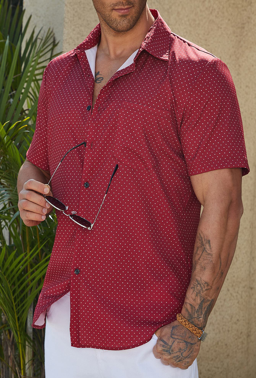

INFO - 2023-12-28 19:22:10,870 - blip2_vicuna_instruct - freeze vision encoder


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - 2023-12-28 19:24:12,947 - blip2 - load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/InstructBLIP/instruct_blip_vicuna7b_trimmed.pth
WARNING - 2023-12-28 19:24:14,943 - warnings - /home/airaiot/miniconda3/envs/adapter/lib/python3.8/site-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(

WARNING - 2023-12-28 19:24:14,944 - warnings - /home/airaiot/miniconda3/envs/adapter/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or un

['The man in the image is wearing a black t-shirt and a pair of white pants. He is sitting on a chair, leaning back, and appears to be enjoying his time at the restaurant or café.']
['In the image, a man is sitting at a table in a restaurant. He is wearing a black t-shirt and white pants, and he appears to be enjoying his meal. There are multiple chairs around the table, with one chair being closer to the man and the others positioned further away from him. There is also a vase of flowers on the table, adding a touch of color and decoration to the scene.']


In [4]:
from lavis.models import load_model_and_preprocess

display(test_img2.resize((256, 378)))

model_instructBlip, vis_processors, _ = load_model_and_preprocess(name="blip2_vicuna_instruct", 
                                                                    model_type="vicuna7b", 
                                                                    is_eval=True, 
                                                                    device=device)

image_ = vis_processors["eval"](test_img).unsqueeze(0).to(device)
caption_test = model_instructBlip.generate({"image": image_, 
                                            "prompt": "Just describe the man's clothes as specifically as you can."})
print(caption_test)

caption_test2 = model_instructBlip.generate(samples={"image": image_, 
                                                     "prompt": "Only describe the background of this image around this man, as much as possible."}, 
                                            use_nucleus_sampling=True, 
                                            top_p=0.9, 
                                            temperature=1)
print(caption_test2)

经过先前的warm up，我们开始进行背景识别任务

实测在RTX 3090上的执行时间为：`229min 37s`

In [ ]:
def generate_image_dict(model, processor, image_folder) -> Dict[str, str]:
    rt_dict: Dict[str, str] = {}
    image_names = os.listdir(image_folder)
    prompt = "Just describe the man's clothes as specifically as you can."
    
    for img_name in image_names:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path).convert('RGB')
        image_tensor = processor["eval"](img).unsqueeze(0).to(device)
        caption: str = model.generate(samples={"image": image_tensor,
                                                "prompt": prompt},
                                      use_nucleus_sampling=True, 
                                      top_p=0.9, 
                                      temperature=1)[0]

        # find "In the background, " in the caption
        
        rt_dict[img_name] = caption
    return rt_dict

# image2_caption_dict = generate_background_dict(model_instructBlip, vis_processors, fashion_new_dataset_path)

# # store the background_caption_dict to json file
# with open(os.path.join('../dataset/fashion-new/', 'image_caption.json'), 'w') as f:
#     json.dump(image2_caption_dict, f)

In [ ]:

def generate_background_dict(model, processor, image_folder) -> Dict[str, str]:
    rt_dict: Dict[str, str] = {}
    image_names = os.listdir(image_folder)
    prompt = "Describe the background of the image, without details of the person's clothing or appearance"
    key_string = "He is "
    len_key_string = len(key_string)
    
    for img_name in image_names:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path).convert('RGB')
        image_tensor = processor["eval"](img).unsqueeze(0).to(device)
        caption: str = model.generate(samples={"image": image_tensor,
                                                "prompt": prompt},
                                      use_nucleus_sampling=True, 
                                      top_p=0.9, 
                                      temperature=1)[0]

        # find "In the background, " in the caption
        
        idx = caption.find(key_string)
        if idx != -1:
            caption = caption[:idx]
        else:
            caption = caption
            
        rt_dict[img_name] = caption
    return rt_dict

background_caption_dict = generate_background_dict(model_instructBlip, vis_processors, fashion_new_dataset_path)

# store the background_caption_dict to json file
with open(os.path.join('../dataset/fashion-new/', 'background_caption.json'), 'w') as f:
    json.dump(background_caption_dict, f)
    

NameError: name 'image_caption_dict' is not defined